In [115]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F


In [116]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
EPOCH = 150
BATCH_SIZE = 50
LR = 1e-2

In [117]:
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.CIFAR10(
    root='dataset',
    train=True,
    download=True,
    transform=transform
)
test_dataset = torchvision.datasets.CIFAR10(
    root='dataset',
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


### ResNet

In [105]:
def conv3_3(in_channels,out_channels,stride=1,downsample=None):
    return nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=stride,padding=1,bias=False)

In [106]:
# 残差块
class ResidualBlock(nn.Module):
    def __init__(self,in_channels,out_channels,stride=1,downsampe=None):
        super(ResidualBlock,self).__init__()
        self.conv1 = conv3_3(in_channels,out_channels,stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3_3(out_channels,out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsampe
    def forward(self,x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [107]:
# ResNet 定义
class ResNet(nn.Module):
    def __init__(self,block,layers,num_classes=10):
        super(ResNet,self).__init__()
        self.in_channels = 16
        self.conv = conv3_3(3,16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block,16,layers[0])
        self.layer2 = self.make_layer(block,32,layers[1],2)
        self.layer3 = self.make_layer(block,64,layers[2],2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64,num_classes)
        
    def make_layer(self,block,out_channels,blocks,stride=1):
        downsample = None
        if(stride!=1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3_3(self.in_channels,out_channels,stride,downsample),
                nn.BatchNorm2d(out_channels)
            )
        layers = []
        layers.append(block(self.in_channels,out_channels,stride,downsample))
        self.in_channels = out_channels
        for i in range(1,blocks):
            layers.append(block(out_channels,out_channels))
        return nn.Sequential(*layers)

    def forward(self,x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


In [108]:
model = ResNet(ResidualBlock,[2,2,2]).to(device)
model

ResNet(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

In [109]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=LR,momentum=0.5)

In [110]:
def update_lr(optimizer,lr):  # ResNet 更新LR
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [111]:
total_step = len(train_loader)
curr_lr = LR
running_loss = []
for epoch in range(EPOCH):
    loss_ = 0.0
    for i, (images,labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            loss_ += loss.item()
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}".format(epoch+1, EPOCH, i+1, total_step, loss.item()))
    running_loss.append(loss_/10)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _,predicted = torch.max(outputs,dim=1)
        total += labels.size(0)
        correct += (predicted==labels).sum().item()
    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Epoch [1/150], Step [100/1000] Loss: 2.0022
Epoch [1/150], Step [200/1000] Loss: 1.7663
Epoch [1/150], Step [300/1000] Loss: 1.6006
Epoch [1/150], Step [400/1000] Loss: 1.7472
Epoch [1/150], Step [500/1000] Loss: 1.7332
Epoch [1/150], Step [600/1000] Loss: 1.4727
Epoch [1/150], Step [700/1000] Loss: 1.5898
Epoch [1/150], Step [800/1000] Loss: 1.5448
Epoch [1/150], Step [900/1000] Loss: 1.3023
Epoch [1/150], Step [1000/1000] Loss: 1.2925
Epoch [2/150], Step [100/1000] Loss: 1.0750
Epoch [2/150], Step [200/1000] Loss: 1.4161
Epoch [2/150], Step [300/1000] Loss: 1.1830
Epoch [2/150], Step [400/1000] Loss: 1.3776
Epoch [2/150], Step [500/1000] Loss: 1.1476
Epoch [2/150], Step [600/1000] Loss: 1.0039
Epoch [2/150], Step [700/1000] Loss: 1.0397
Epoch [2/150], Step [800/1000] Loss: 1.2768
Epoch [2/150], Step [900/1000] Loss: 1.2983
Epoch [2/150], Step [1000/1000] Loss: 1.1397
Epoch [3/150], Step [100/1000] Loss: 0.9688
Epoch [3/150], Step [200/1000] Loss: 0.9988
Epoch [3/150], Step [300/1000]

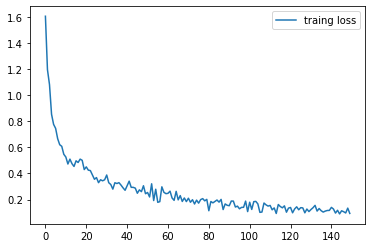

In [113]:
import matplotlib.pyplot as plt
plt.plot(running_loss,label="traing loss")
plt.legend()

In [114]:
torch.save(model.state_dict(),'ResNet.ckpt')

### VGG 16

In [82]:
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            #1
            nn.Conv2d(3,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            #2
            nn.Conv2d(64,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            #3
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            #4
            nn.Conv2d(128,128,kernel_size=3,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            #5
            nn.Conv2d(128,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            #6
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            #7
            nn.Conv2d(256,256,kernel_size=3,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            #8
            nn.Conv2d(256,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            #9
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            #10
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            #11
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            #12
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            #13
            nn.Conv2d(512,512,kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.AvgPool2d(kernel_size=1,stride=1),
            )
        self.classifier = nn.Sequential(
            #14
            nn.Linear(512,4096),
            nn.ReLU(True),
            nn.Dropout(),
            #15
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            #16
            nn.Linear(4096,num_classes),
            )
        #self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x) 
#        print(out.shape)
        out = out.view(out.size(0), -1)
#        print(out.shape)
        out = self.classifier(out)
#        print(out.shape)
        return out

In [83]:
model = VGG16()
model = model.cuda()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=LR,momentum=0.5)

In [85]:
total_step = len(train_loader)
curr_lr = LR
running_loss = []
for epoch in range(EPOCH):
    loss_ = 0.0
    for i, (images,labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            loss_ += loss.item()
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}".format(epoch+1, EPOCH, i+1, total_step, loss.item()))
    running_loss.append(loss_/10)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _,predicted = torch.max(outputs,dim=1)
        total += labels.size(0)
        correct += (predicted==labels).sum().item()
    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Epoch [1/150], Step [100/1000] Loss: 1.9471
Epoch [1/150], Step [200/1000] Loss: 1.7174
Epoch [1/150], Step [300/1000] Loss: 1.8678
Epoch [1/150], Step [400/1000] Loss: 1.4527
Epoch [1/150], Step [500/1000] Loss: 1.5449
Epoch [1/150], Step [600/1000] Loss: 1.3670
Epoch [1/150], Step [700/1000] Loss: 1.3894
Epoch [1/150], Step [800/1000] Loss: 1.4311
Epoch [1/150], Step [900/1000] Loss: 1.2630
Epoch [1/150], Step [1000/1000] Loss: 1.1850
Epoch [2/150], Step [100/1000] Loss: 1.1011
Epoch [2/150], Step [200/1000] Loss: 0.9994
Epoch [2/150], Step [300/1000] Loss: 1.0445
Epoch [2/150], Step [400/1000] Loss: 0.9647
Epoch [2/150], Step [500/1000] Loss: 0.6947
Epoch [2/150], Step [600/1000] Loss: 0.7610
Epoch [2/150], Step [700/1000] Loss: 1.1510
Epoch [2/150], Step [800/1000] Loss: 1.1078
Epoch [2/150], Step [900/1000] Loss: 1.2313
Epoch [2/150], Step [1000/1000] Loss: 0.8118
Epoch [3/150], Step [100/1000] Loss: 1.0950
Epoch [3/150], Step [200/1000] Loss: 1.0121
Epoch [3/150], Step [300/1000]

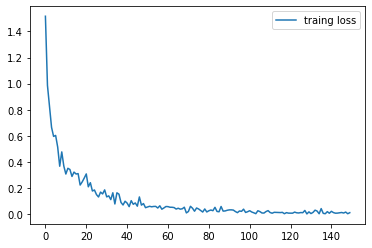

In [86]:
import matplotlib.pyplot as plt
plt.plot(running_loss,label="traing loss")
plt.legend()

In [87]:
torch.save(model.state_dict(),'VGG16.ckpt')

### InceptionNet V1

In [118]:
class InceptionV1_base(nn.Module):
    def __init__(self, in_channel, layers=[64,96,128,16,32,32]):
        super(InceptionV1_base,self).__init__()
        self.branch_1 = nn.Sequential(
        nn.Conv2d(in_channel,layers[0],kernel_size=1,bias=False),
        nn.ReLU6(inplace=True),
        )
        self.branch_2 = nn.Sequential(
        nn.Conv2d(in_channel,layers[1],kernel_size=1,bias=False),
        nn.ReLU6(inplace=True),
        nn.Conv2d(layers[1],layers[2],kernel_size=3,stride=1,padding=1,bias=False),
        nn.ReLU6(inplace=True),
        )
        self.branch_3 = nn.Sequential(
        nn.Conv2d(in_channel,layers[3],kernel_size=1,stride=1,padding=0,bias=False),
        nn.ReLU6(inplace=True),
        nn.Conv2d(layers[3],layers[4],kernel_size=3,stride=1,padding=1,bias=False),
        nn.ReLU6(inplace=True),
        )
        self.branch_4 = nn.Sequential(
        nn.MaxPool2d(kernel_size=3,stride=1,padding=1),
        nn.Conv2d(in_channel,layers[5],kernel_size=1,stride=1,padding=0,bias=False),
        nn.ReLU6(inplace=True),
        )
    def forward(self,x):
        b_1 = self.branch_1(x)
        b_2 = self.branch_2(x)
        b_3 = self.branch_3(x)
        b_4 = self.branch_4(x)
        y = torch.cat([b_1,b_2,b_3,b_4],dim=1)
        return y

In [119]:
class InceptionV1(nn.Module):
    def __init__(self,num_class,block=InceptionV1_base,grayscale=False):
        if grayscale:
            dim = 1
        else :
            dim = 3
        self.block = block
        super(InceptionV1,self).__init__()
        self.bottle = nn.Sequential(
        nn.Conv2d(dim,64,kernel_size=7,stride=2,padding=3,bias=False),
        nn.ReLU6(inplace=True),
        nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
        nn.Conv2d(64,64,kernel_size=1,stride=1,padding=0,bias=False),
        nn.ReLU6(inplace=True),
        nn.Conv2d(64,192,kernel_size=3,stride=1,padding=1,bias=False),
        nn.ReLU6(inplace=True),
        nn.MaxPool2d(kernel_size=3,stride=2,padding=1),
        )
        self.layer1 = self._make_layer(192,[64,96,128,16,32,32  ])
        self.layer2 = self._make_layer(256,[128,128,192,32,96,64])
        self.max = nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        self.layer3 = self._make_layer(480,[192,96,208,16,48,64])
        self.layer4 = self._make_layer(512,[160,112,224,24,64,64])
        self.layer5 = self._make_layer(512,[128,128,256,24,64,64])
        self.layer6 = self._make_layer(512,[112,144,288,32,64,64])
        self.layer7 = self._make_layer(528,[256,160,320,32,128,128])
        self.layer8 = self._make_layer(832,[256,160,320,32,128,128])
        self.layer9 = self._make_layer(832,[384,192,384,48,128,128])
        # self.avg = nn.AvgPool2d(7,stride=1)
        self.bottom = nn.Sequential(
        nn.Dropout(p=0.8),
        nn.Linear(1024,num_class),
        )
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] *m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5 )
            elif  isinstance(m,nn.Linear):
                m.weight.data.normal_(0,0.01)
                m.bias.data.zero_()
    def _make_layer(self, in_channel,layers ):
        blocks = []
        blocks.append( self.block(in_channel,layers) )
        return nn.Sequential(*blocks)
    def forward(self,x):
        x = self.bottle(x)
        x =self.layer1(x)
        x =self.layer2(x)
        x = self.max(x)
        x =self.layer3(x)
        x =self.layer4(x)
        x =self.layer5(x)
        x =self.layer6(x)
        x = self.max(x)
        x =self.layer7(x)
        x =self.layer8(x)
        x =self.layer9(x)
        # x = self.avg(x)
        x = x.view(x.size(0),-1 )
        x = self.bottom(x)
        pro = F.softmax(x)
        return x , pro

In [120]:
model = InceptionV1(num_class=10).to(device)
model

InceptionV1(
  (bottle): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): ReLU6(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (4): ReLU6(inplace=True)
    (5): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): ReLU6(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): InceptionV1_base(
      (branch_1): Sequential(
        (0): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): ReLU6(inplace=True)
      )
      (branch_2): Sequential(
        (0): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): ReLU6(inplace=True)
        (2): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (3): ReLU6(inplace=Tru

In [121]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=LR,momentum=0.5)

In [122]:
total_step = len(train_loader)
curr_lr = LR
running_loss = []
for epoch in range(EPOCH):
    loss_ = 0.0
    for i, (images,labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs,_ = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            loss_ += loss.item()
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}".format(epoch+1, EPOCH, i+1, total_step, loss.item()))
    running_loss.append(loss_/10)
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs,_ = model(images)
        _,predicted = torch.max(outputs,dim=1)
        total += labels.size(0)
        correct += (predicted==labels).sum().item()
    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

<ipython-input-119-45eb1bd6148c>:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pro = F.softmax(x)


Epoch [1/150], Step [100/1000] Loss: 2.5398
Epoch [1/150], Step [200/1000] Loss: 2.5143
Epoch [1/150], Step [300/1000] Loss: 2.5887
Epoch [1/150], Step [400/1000] Loss: 2.5797
Epoch [1/150], Step [500/1000] Loss: 2.4617
Epoch [1/150], Step [600/1000] Loss: 2.5196
Epoch [1/150], Step [700/1000] Loss: 2.4950
Epoch [1/150], Step [800/1000] Loss: 2.4702
Epoch [1/150], Step [900/1000] Loss: 2.5340
Epoch [1/150], Step [1000/1000] Loss: 2.4482
Epoch [2/150], Step [100/1000] Loss: 2.5977
Epoch [2/150], Step [200/1000] Loss: 2.3682
Epoch [2/150], Step [300/1000] Loss: 2.4268
Epoch [2/150], Step [400/1000] Loss: 2.1523
Epoch [2/150], Step [500/1000] Loss: 2.2250
Epoch [2/150], Step [600/1000] Loss: 2.3747
Epoch [2/150], Step [700/1000] Loss: 2.3254
Epoch [2/150], Step [800/1000] Loss: 2.2248
Epoch [2/150], Step [900/1000] Loss: 2.2150
Epoch [2/150], Step [1000/1000] Loss: 2.4824
Epoch [3/150], Step [100/1000] Loss: 2.5237
Epoch [3/150], Step [200/1000] Loss: 2.3056
Epoch [3/150], Step [300/1000]

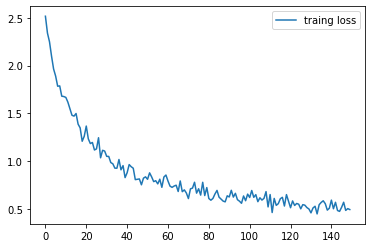

In [123]:
import matplotlib.pyplot as plt
plt.plot(running_loss,label="traing loss")
plt.legend()

In [ ]:
torch.save(model.state_dict(),'InceptionNet_V1.ckpt')